In [ ]:
import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import polars as pl
import cv2
from IPython.display import Image, display
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.layers import Dense, MaxPooling2D,Conv2D
from tensorflow.keras.layers import Input,Activation,Add
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,Dense,Dropout,BatchNormalization,Flatten,Input

#import face_recognition

In [ ]:
!git clone https://github.com/CptJarkov/MLProj.git

Cloning into 'MLProj'...
remote: Enumerating objects: 28805, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 28805 (delta 2), reused 8 (delta 2), pack-reused 28795
Receiving objects: 100% (28805/28805), 311.28 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Updating files: 100% (29046/29046), done.


In [ ]:
data=pd.read_csv('/content/MLProj/affectnet/labels.csv')
data['pth'] = '/content/MLProj/affectnet/' + data['pth'].astype(str)

# # Zapisz zmodyfikowany DataFrame z powrotem do pliku CSV
# data.to_csv('/content/MLProj/affectnet/labels.csv', index=False)

In [ ]:
data

,Unnamed: 0,pth,label,relFCs
0,0,/content/MLProj/affectnet/anger/image0000006.jpg,surprise,0.873142
1,1,/content/MLProj/affectnet/anger/image0000060.jpg,anger,0.852311
2,2,/content/MLProj/affectnet/anger/image0000061.jpg,anger,0.800957
3,3,/content/MLProj/affectnet/anger/image0000066.jpg,disgust,0.843079
4,4,/content/MLProj/affectnet/anger/image0000106.jpg,anger,0.849108
...,...,...,...,...
28170,28170,/content/MLProj/affectnet/surprise/image003496...,surprise,0.825263
28171,28171,/content/MLProj/affectnet/surprise/image003496...,surprise,0.738646
28172,28172,/content/MLProj/affectnet/surprise/image003496...,surprise,0.774524
28173,28173,/content/MLProj/affectnet/surprise/image003497...,neutral,0.766952


In [ ]:
def image_show(i):
    row = data.iloc[i]
    pth = row[1]
    image_path = pth
    img = mpimg.imread(image_path)
    return img, row[2]

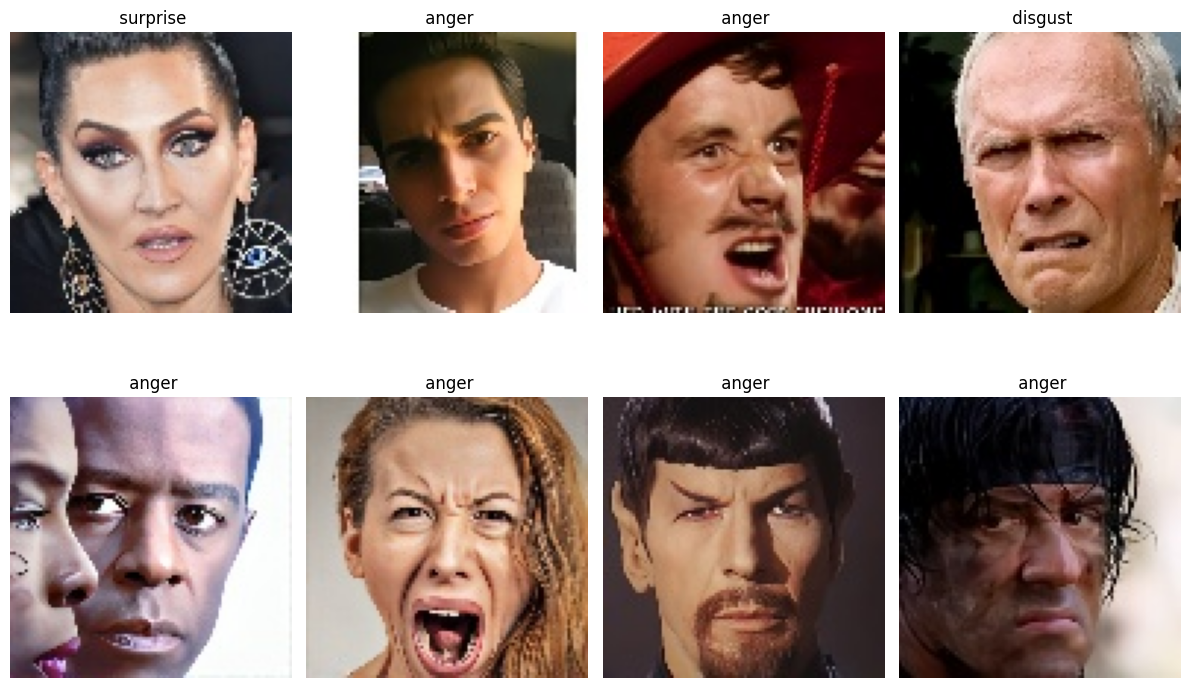

In [ ]:
# def image_show(i):
#     row = data.iloc[i]
#     pth = row['pth']
#     label = row['label']
#     image_path = pth
#     img = mpimg.imread(image_path)
#     return img, label

# Displaying the first 8 images from the file
i = 8
num_cols = int(i / 2)
num_rows = int(i / num_cols) + i % 2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0, i):
    row = i // num_cols
    col = i % num_cols
    img_path, title = image_show(i)
    axes[row, col].imshow(img_path)
    axes[row, col].set_title(f' {title}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
# Extract features (image paths) and labels
X = data['pth'].values
y = data['label'].values

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    #Converting image to grey
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    #Resizing here not required as all image is 96*96 pixel
    img_resized = cv2.resize(img_gray, (96, 96))
#     Normalizing pixel from 0 to 1 range
    img_normalized = img_resized / 255.0
    return img_normalized


X_preprocessed=np.array([preprocess_image(image_path) for image_path in X])

# Labeling the data
le = LabelEncoder()
y_preprocessed = to_categorical(le.fit_transform(y))

In [ ]:
# Extract features (image paths) and labels
X = data['pth'].to_numpy()
y = data['label'].to_numpy()

In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img_gray, (96, 96))
    img_normalized = img_resized / 255.0
    return img_normalized


X_preprocessed=np.array([preprocess_image(image_path) for image_path in X])

# Labeling the data
le = LabelEncoder()
y_preprocessed = to_categorical(le.fit_transform(y))

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size=0.2, random_state=42, stratify=y)

In [ ]:
input_shape=X_preprocessed[0].shape

input_shape

(96, 96)

In [ ]:
label_mapping={0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

In [ ]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras import models, layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
import platform
from keras.optimizers import Adam

input_shape = (96, 96, 1) # Dla obrazów w skali szarości użyj (96, 96, 1)

model_2 = Sequential()

model_2.add(Conv2D(32, (3,3), activation="selu", input_shape=input_shape))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))


model_2.add(Conv2D(64, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Conv2D(128, (3,3), activation="selu"))
model_2.add(BatchNormalization())
model_2.add(MaxPool2D(pool_size=(2,2)))
model_2.add(Dropout(0.25))

model_2.add(Flatten())
model_2.add(Dense(256, activation='selu', kernel_regularizer=l2(0.01)))
model_2.add(BatchNormalization())
model_2.add(Dropout(0.5))
model_2.add(Dense(8, activation='softmax'))

model_2.compile(optimizer = Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 94, 94, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 47, 47, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 47, 47, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 45, 45, 64)        2

In [ ]:
history = model_2.fit(X_train, y_train, batch_size=64,
                    epochs=30,
                    validation_data=(X_test, y_test),

                    callbacks = [EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                 ReduceLROnPlateau(patience=2, verbose=1),
                                 ModelCheckpoint('best_model.weights.h5',
                                                 save_best_only=True,
                                                 save_weights_only=True,
                                                 monitor='val_accuracy',
                                                 mode='max')],
                    verbose=1)

Epoch 1/30
353/353 [==============================] - 17s 48ms/step - loss: 0.8965 - accuracy: 0.7890 - val_loss: 1.2554 - val_accuracy: 0.6499 - lr: 1.0000e-05
Epoch 2/30
353/353 [==============================] - 15s 43ms/step - loss: 0.8766 - accuracy: 0.7941 - val_loss: 1.2425 - val_accuracy: 0.6483 - lr: 1.0000e-05
Epoch 3/30
353/353 [==============================] - 15s 44ms/step - loss: 0.8662 - accuracy: 0.7929 - val_loss: 1.2422 - val_accuracy: 0.6500 - lr: 1.0000e-05
Epoch 4/30
353/353 [==============================] - 15s 42ms/step - loss: 0.8498 - accuracy: 0.7993 - val_loss: 1.2365 - val_accuracy: 0.6511 - lr: 1.0000e-05
Epoch 5/30
234/353 [==================>...........] - ETA: 4s - loss: 0.8305 - accuracy: 0.8065

<Axes: >

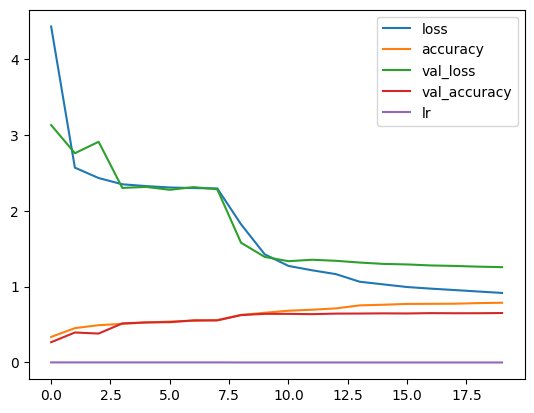

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
label_mapping={0: 'anger',
 1: 'contempt',
 2: 'disgust',
 3: 'fear',
 4: 'happy',
 5: 'neutral',
 6: 'sad',
 7: 'surprise'}

177/177 [==============================] - 1s 5ms/step
      Label  Precision    Recall  F1-score       AUC
0     anger   0.671498  0.577562  0.620998  0.927207
1  contempt   0.591760  0.730354  0.653793  0.944404
2   disgust   0.573611  0.595101  0.584158  0.906947
3      fear   0.753659  0.507389  0.606477  0.935566
4     happy   0.847973  0.868512  0.858120  0.985883
5   neutral   0.499203  0.547203  0.522102  0.908331
6       sad   0.599174  0.484140  0.535549  0.919517
7  surprise   0.648524  0.761647  0.700548  0.934600
8   Overall   0.648175  0.633989  0.635218  0.932246


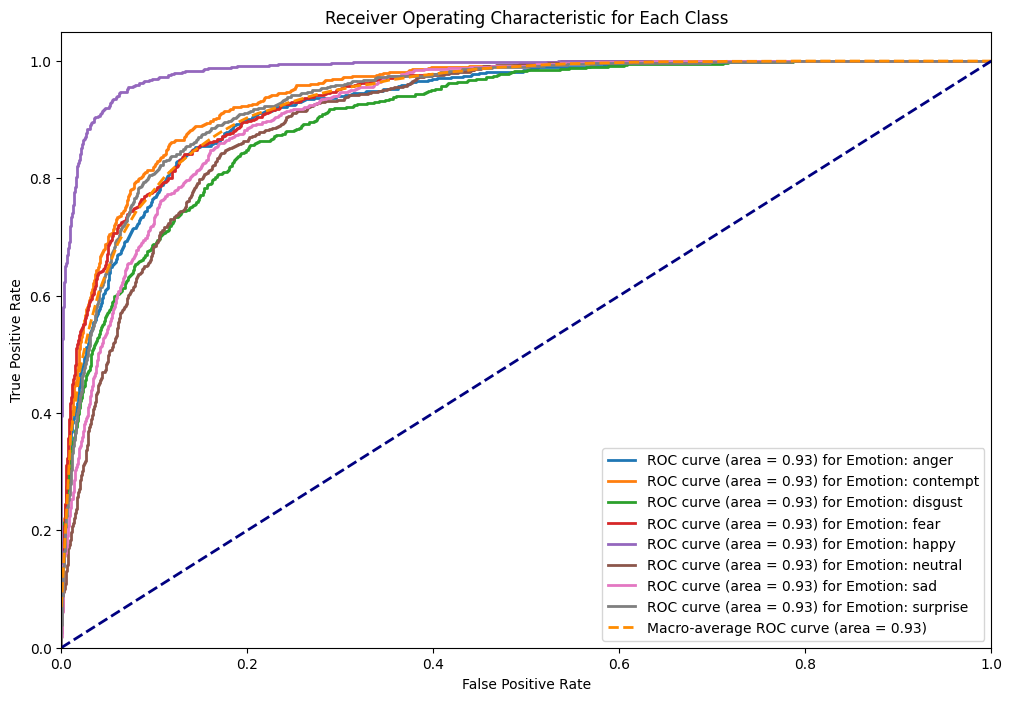

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

y_pred_prob=model_2.predict(X_test)
# Zamiana prawdopodobieństw na binarne predykcje
y_pred_labels = np.argmax(y_pred_prob, axis=1)

# Zamiana y_test na binarne etykiety
y_true_labels = np.argmax(y_test, axis=1)

# Lista składująca indywidualne wartości precision, recall i F1-score dla każdej klasy
class_metrics = []

# Lista składująca indywidualne wartości AUC i krzywej ROC dla każdej klasy
roc_curves = []


for i in range(8):
    # Zamiana przewidzianych i faktycznych etykiet do binarnych etykiet
    y_pred_binary = (y_pred_labels == i)
    y_true_binary = (y_true_labels == i)

    # Obliczanie precision, recall i F1-score
    precision = precision_score(y_true_binary, y_pred_binary)
    recall = recall_score(y_true_binary, y_pred_binary)
    f1 = f1_score(y_true_binary, y_pred_binary)

    # Obliczanie krzywej ROC
    fpr, tpr, _ = roc_curve(y_true_binary, y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    roc_curves.append((fpr, tpr, label_mapping[i]))

    # Składowanie metryk
    class_metrics.append({
        'Label': label_mapping[i],
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1,
        'AUC': roc_auc
    })



# Kompilowanie krzywej ROC
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.mean([np.interp(mean_fpr, fpr, tpr) for fpr, tpr, _ in roc_curves], axis=0)
macro_auc = auc(mean_fpr, mean_tpr)




# Obliczanie całkowitego precision, recall, and F1-score
overall_precision = precision_score(y_true_labels, y_pred_labels, average='macro')
overall_recall = recall_score(y_true_labels, y_pred_labels, average='macro')
overall_f1 = f1_score(y_true_labels, y_pred_labels, average='macro')

class_metrics.append({
    'Label': 'Overall',
    'Precision': overall_precision,
    'Recall': overall_recall,
    'F1-score': overall_f1,
    'AUC': macro_auc
})


# Tworzenie ramki danych Pandas metryk
metrics_df = pd.DataFrame(class_metrics)

# Opcjonalne wyświetlanie ramki danych metryk
print(metrics_df)


# Wyświetlanie krzywych ROC każdej klasy
plt.figure(figsize=(12, 8))
lw = 2


for fpr, tpr, label in roc_curves:
    plt.plot(fpr, tpr, lw=lw, label='ROC curve (area = {:.2f}) for Emotion: {}'.format(roc_auc, label))

plt.plot(mean_fpr, mean_tpr, color='darkorange', linestyle='--', linewidth=2, label='Macro-average ROC curve (area = {:.2f})'.format(macro_auc))


plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Each Class')
plt.legend(loc='lower right')
plt.show()


In [ ]:
mismatch_index=[]
for i in range(0,len(y_true_labels)):
    if y_true_labels[i]!=y_pred_labels[i]:
        mismatch_index.append(i)

In [ ]:
def pred_vs_actual_label(i):
    i=mismatch_index[i]
    img_array=X_test[i]
    img_array = (img_array * 255).astype(np.uint8)
    pred_label=label_mapping[y_pred_labels[i]]
    actual_label=label_mapping[y_true_labels[i]]
    return img_array,pred_label,actual_label

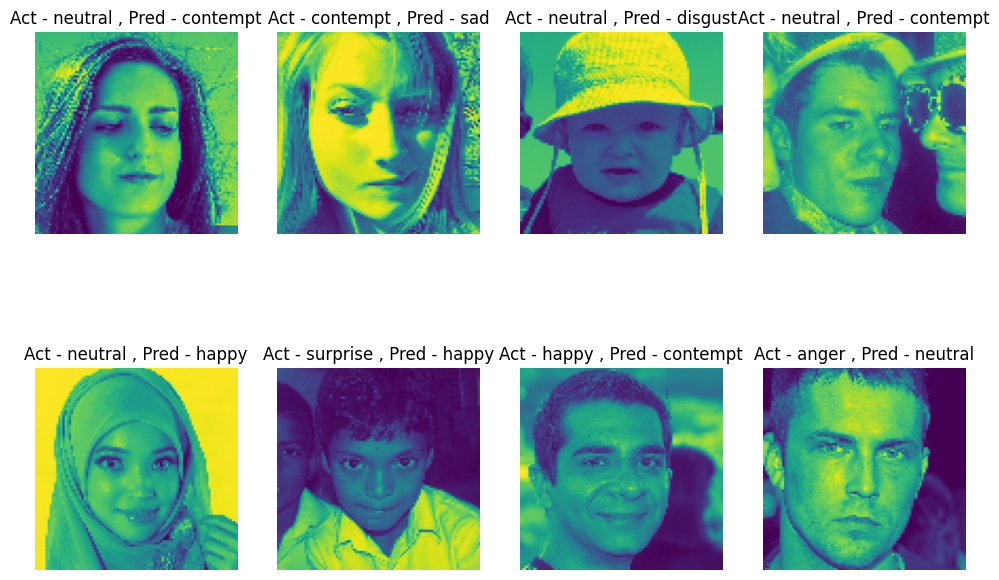

In [ ]:
i=8
num_cols=int(i/2)
num_rows=int(i/num_cols)+i%2
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

for i in range(0,i):
    row = i // num_cols
    col = i % num_cols
    img_array,pred_label,actual_label=pred_vs_actual_label(i)

    axes[row, col].imshow(img_array,cmap= 'gray')
    axes[row, col].set_title(f"Act - {actual_label}"+" , "+f"Pred - {pred_label}")
    axes[row, col].axis('off')

177/177 [==============================] - 1s 5ms/step


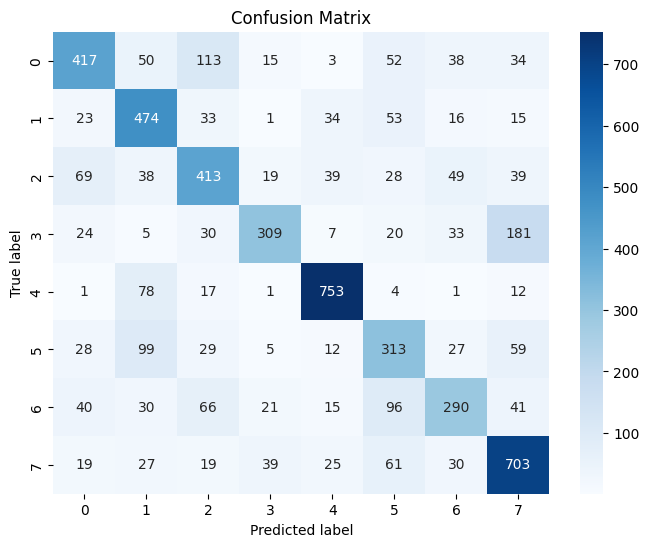

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have trained your model and obtained predictions on test data
# Replace these with your actual predictions and true labels
y_pred = np.argmax(model_2.predict(X_test), axis=1)

y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded true labels back to categorical

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Definicja funkcji, wykrywającej i zaznaczającej twarz na obrazie z kamery

In [ ]:
face_cascade = cv2.CascadeClassifier('/content/MLProj/haarcascade_frontalface_default.xml')

def detect_face(img):
    face_img = img.copy()
    face_rec = face_cascade.detectMultiScale(face_img)

    if len(face_rec) == 0:
        return face_img, None

    for (x, y, w, h) in face_rec:
        cv2.rectangle(face_img, (x, y), (x + w, y + h), color=(0, 0, 255), thickness=4)
        face = face_img[y:y + h, x:x + w]
        return face_img, face

    return face_img, None

Jeśli szary obraz bez konturów.

In [ ]:
cap = cv2.VideoCapture(0)


while True:
    ret,frame = cap.read()
    frame,face = detect_face(frame)
    face = cv2.resize(face,(96,96))
    face_for_model = cv2.cvtColor(face,cv2.COLOR_BGR2GRAY)
    prediction = model_2.predict(face_for_model)
# ####
# DODANIE NAPISU
# ######
    cv2.imshow('Video face detect',face_for_model)
    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()

Jeśli z konturami

In [ ]:

cap = cv2.VideoCapture(0)


while True:
    ret,frame = cap.read()

    frame,face = detect_face(frame)

    face = cv2.resize(face,(96,96))

    face = cv2.cvtColor(face,cv2.COLOR_BGR2RGB)
    med_face = np.median(face)
    blurred_face = cv2.blur(face,ksize=(3,3))
    lower_val = int(max(0,.3*med_face))
    upper_val = int(min(255,1.7*med_face))
    face_for_model = cv2.Canny(face,threshold1=lower_val,threshold2=upper_val)

    prediction = model_2.predict(face_for_model)

# ####
# DODANIE NAPISU
# ######

    cv2.imshow('Video face detect',frame)

    if cv2.waitKey(1) & 0xFF == 27:
        break

cap.release()
cv2.destroyAllWindows()